# YOLO: Real-Time Object Detection

### By Albert Zunran Guo (ZGU682)

You only look once (YOLO) is a state-of-the-art, real-time object detection system. In this project I implemented its latest version YOLOv3. <br />

This Jupyter Notebooks is adapted from the tutorial mentioned in the references section at the bottom. Previously the code was open-sourced in a tightly packaged and fragmented way. In this notebook, I integrated everything together in a simplified pipeline. 

To demonstrate a solid understanding of the model structure, I also added more comments throughout this notebook and figures from the original paper.

In [1]:
import os
import os.path as osp
import time
import random
import pickle as pkl
from IPython.display import Image

import cv2
import numpy as np
import pandas as pd
import torch 
import torch.nn as nn
import torch.nn.functional as F 
from torch.autograd import Variable

## Build Model in PyTorch
In this section, we extract layer information from a Darknet (a Neural Network written in C) configuration file; and then translate this information to build the model in PyTorch.

In [17]:
def parse_cfg(cfgfile):
    """
    Reads in a configuration file.
    Returns a list of blocks. 
    Each blocks describes a block in the neural network to be built. 
    Block is represented as a dictionary in the list.
    """
    file = open(cfgfile, 'r')
    lines = file.read().split('\n')                        # store the lines in a list
    lines = [x for x in lines if len(x) > 0]               # get read of the empty lines 
    lines = [x for x in lines if x[0] != '#']              # get rid of comments
    lines = [x.rstrip().lstrip() for x in lines]           # get rid of fringe whitespaces
    block = {}
    blocks = []
    
    for line in lines:
        if line[0] == "[":               # This marks the start of a new block
            if len(block) != 0:          # If block is not empty, implies it is storing values of previous block.
                blocks.append(block)     # add it the blocks list
                block = {}               # re-init the block
            block["type"] = line[1:-1].rstrip()     
        else:
            key, value = line.split("=") 
            block[key.rstrip()] = value.lstrip()
    blocks.append(block)
    return blocks


class EmptyLayer(nn.Module):
    def __init__(self):
        super(EmptyLayer, self).__init__()
        

class DetectionLayer(nn.Module):
    def __init__(self, anchors):
        super(DetectionLayer, self).__init__()
        self.anchors = anchors

        
def create_modules(blocks):
    # Captures the information about the input and pre-processing
    net_info = blocks[0]    
    module_list = nn.ModuleList()
    prev_filters = 3
    output_filters = []
    
    # extract information of each block
    # create a PyTorch module accordingly
    # append each module to module_list
    for index, x in enumerate(blocks[1:]):
        module = nn.Sequential()
        
        # if the block is a convolutional layer
        if x["type"] == "convolutional":
            # extract layer information (activation, batch_normalize, bias, padding, etc.)
            activation = x["activation"]
            
            try:
                batch_normalize = int(x["batch_normalize"])
                bias = False
            except:
                batch_normalize = 0
                bias = True
        
            filters= int(x["filters"])
            padding = int(x["pad"])
            kernel_size = int(x["size"])
            stride = int(x["stride"])
        
            if padding: pad = (kernel_size - 1) // 2
            else: pad = 0
        
            # add convolutional layer
            conv = nn.Conv2d(prev_filters, filters, kernel_size, stride, pad, bias=bias)
            module.add_module("conv_{0}".format(index), conv)
        
            # add batch normalization layer
            if batch_normalize:
                bn = nn.BatchNorm2d(filters)
                module.add_module("batch_norm_{0}".format(index), bn)
        
            # add activation layer (either Linear or a Leaky ReLU for YOLO)
            if activation == "leaky":
                activn = nn.LeakyReLU(0.1, inplace=True)
                module.add_module("leaky_{0}".format(index), activn)
        
        # if the block is an upsampling layer (we use Bilinear2dUpsampling)
        elif (x["type"] == "upsample"):
            stride = int(x["stride"])
            upsample = nn.Upsample(scale_factor=2, mode="nearest")
            module.add_module("upsample_{}".format(index), upsample)
                
        # if the block is a route layer
        elif (x["type"] == "route"):
            x["layers"] = x["layers"].split(',')
            start = int(x["layers"][0])
            
            try: end = int(x["layers"][1])
            except: end = 0
            
            # positive anotation
            if start > 0: start = start - index
            if end > 0: end = end - index
            
            route = EmptyLayer()
            module.add_module("route_{0}".format(index), route)
            
            if end < 0: filters = output_filters[index + start] + output_filters[index + end]
            else: filters = output_filters[index + start]
    
        # shortcut corresponds to skip connection
        elif x["type"] == "shortcut":
            shortcut = EmptyLayer()
            module.add_module("shortcut_{}".format(index), shortcut)
            
        # Yolo is the detection layer
        elif x["type"] == "yolo":
            mask = x["mask"].split(",")
            mask = [int(x) for x in mask]
    
            anchors = x["anchors"].split(",")
            anchors = [int(a) for a in anchors]
            anchors = [(anchors[i], anchors[i+1]) for i in range(0, len(anchors),2)]
            anchors = [anchors[i] for i in mask]
    
            detection = DetectionLayer(anchors)
            module.add_module("Detection_{}".format(index), detection)
                              
        module_list.append(module)
        prev_filters = filters
        output_filters.append(filters)
        
    return (net_info, module_list)


class Darknet(nn.Module):
    def __init__(self, cfgfile):
        super(Darknet, self).__init__()
        self.blocks = parse_cfg(cfgfile)
        self.net_info, self.module_list = create_modules(self.blocks)
        
    def forward(self, x):
        modules = self.blocks[1:]
        outputs = {}   # cache the outputs for the route layer
        write = 0
        
        for i, module in enumerate(modules):        
            module_type = (module["type"])
            
            if module_type == "convolutional" or module_type == "upsample": x = self.module_list[i](x)
                
            elif module_type == "route":
                layers = module["layers"]
                layers = [int(a) for a in layers]
    
                if (layers[0]) > 0: layers[0] = layers[0] - i
                if len(layers) == 1: x = outputs[i + (layers[0])]
                else:
                    if (layers[1]) > 0: layers[1] = layers[1] - i
                    map1 = outputs[i + layers[0]]
                    map2 = outputs[i + layers[1]]
                    x = torch.cat((map1, map2), 1)
    
            elif module_type == "shortcut":
                from_ = int(module["from"])
                x = outputs[i-1] + outputs[i+from_]
    
            elif module_type == 'yolo':        
                anchors = self.module_list[i][0].anchors
                #Get the input dimensions
                inp_dim = int (self.net_info["height"])
        
                #Get the number of classes
                num_classes = int (module["classes"])
        
                #Transform 
                x = x.data
                x = predict_transform(x, inp_dim, anchors, num_classes)
                if not write:              #if no collector has been intialised. 
                    detections = x
                    write = 1
                else:       
                    detections = torch.cat((detections, x), 1)
        
            outputs[i] = x
        
        return detections


    def load_weights(self, weightfile):
        fp = open(weightfile, "rb")
        # The first 5 values are header information 
        # 1. Major version number
        # 2. Minor Version Number
        # 3. Subversion number 
        # 4,5. Images seen by the network (during training)
        header = np.fromfile(fp, dtype = np.int32, count = 5)
        self.header = torch.from_numpy(header)
        self.seen = self.header[3]   
        weights = np.fromfile(fp, dtype = np.float32)
        ptr = 0
        
        for i in range(len(self.module_list)):
            module_type = self.blocks[i + 1]["type"]
    
            # load weights if module_type is convolutional, otherwise ignore
            if module_type == "convolutional":
                model = self.module_list[i]
                try:
                    batch_normalize = int(self.blocks[i+1]["batch_normalize"])
                except:
                    batch_normalize = 0
            
                conv = model[0]
                
                if batch_normalize:
                    bn = model[1]
        
                    #Get the number of weights of Batch Norm Layer
                    num_bn_biases = bn.bias.numel()
        
                    #Load the weights
                    bn_biases = torch.from_numpy(weights[ptr : ptr+num_bn_biases])
                    ptr += num_bn_biases
        
                    bn_weights = torch.from_numpy(weights[ptr : ptr+num_bn_biases])
                    ptr += num_bn_biases
        
                    bn_running_mean = torch.from_numpy(weights[ptr : ptr+num_bn_biases])
                    ptr += num_bn_biases
        
                    bn_running_var = torch.from_numpy(weights[ptr : ptr+num_bn_biases])
                    ptr += num_bn_biases
        
                    #reshape the loaded weights according to the dims of the model weights
                    bn_biases = bn_biases.view_as(bn.bias.data)
                    bn_weights = bn_weights.view_as(bn.weight.data)
                    bn_running_mean = bn_running_mean.view_as(bn.running_mean)
                    bn_running_var = bn_running_var.view_as(bn.running_var)
        
                    #Copy the data to model
                    bn.bias.data.copy_(bn_biases)
                    bn.weight.data.copy_(bn_weights)
                    bn.running_mean.copy_(bn_running_mean)
                    bn.running_var.copy_(bn_running_var)
                
                else:
                    #Number of biases
                    num_biases = conv.bias.numel()
                
                    #Load the weights
                    conv_biases = torch.from_numpy(weights[ptr : ptr+num_biases])
                    ptr = ptr + num_biases
                
                    #reshape the loaded weights according to the dims of the model weights
                    conv_biases = conv_biases.view_as(conv.bias.data)
                
                    #Finally copy the data
                    conv.bias.data.copy_(conv_biases)
                    
                #Let us load the weights for the Convolutional layers
                num_weights = conv.weight.numel()
                
                #Do the same as above for weights
                conv_weights = torch.from_numpy(weights[ptr : ptr+num_weights])
                ptr = ptr + num_weights
                
                conv_weights = conv_weights.view_as(conv.weight.data)
                conv.weight.data.copy_(conv_weights)

## Utility Functions

In [18]:
def unique(tensor):
    tensor_np = tensor.cpu().numpy()
    unique_np = np.unique(tensor_np)
    unique_tensor = torch.from_numpy(unique_np)

    tensor_res = tensor.new(unique_tensor.shape)
    tensor_res.copy_(unique_tensor)
    return tensor_res


def bbox_iou(box1, box2):
    """
    Returns the Intersection over Union (IoU) of two bounding boxes
    """
    # coordinates of bounding boxes
    b1_x1, b1_y1, b1_x2, b1_y2 = box1[:,0], box1[:,1], box1[:,2], box1[:,3]
    b2_x1, b2_y1, b2_x2, b2_y2 = box2[:,0], box2[:,1], box2[:,2], box2[:,3]

    # corrdinates of the intersection rectangle
    inter_rect_x1 =  torch.max(b1_x1, b2_x1)
    inter_rect_y1 =  torch.max(b1_y1, b2_y1)
    inter_rect_x2 =  torch.min(b1_x2, b2_x2)
    inter_rect_y2 =  torch.min(b1_y2, b2_y2)

    # intersection area
    inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) * torch.clamp(inter_rect_y2 - inter_rect_y1 + 1, min=0)

    # union area
    b1_area = (b1_x2 - b1_x1 + 1)*(b1_y2 - b1_y1 + 1)
    b2_area = (b2_x2 - b2_x1 + 1)*(b2_y2 - b2_y1 + 1)

    iou = inter_area / (b1_area + b2_area - inter_area)
    return iou

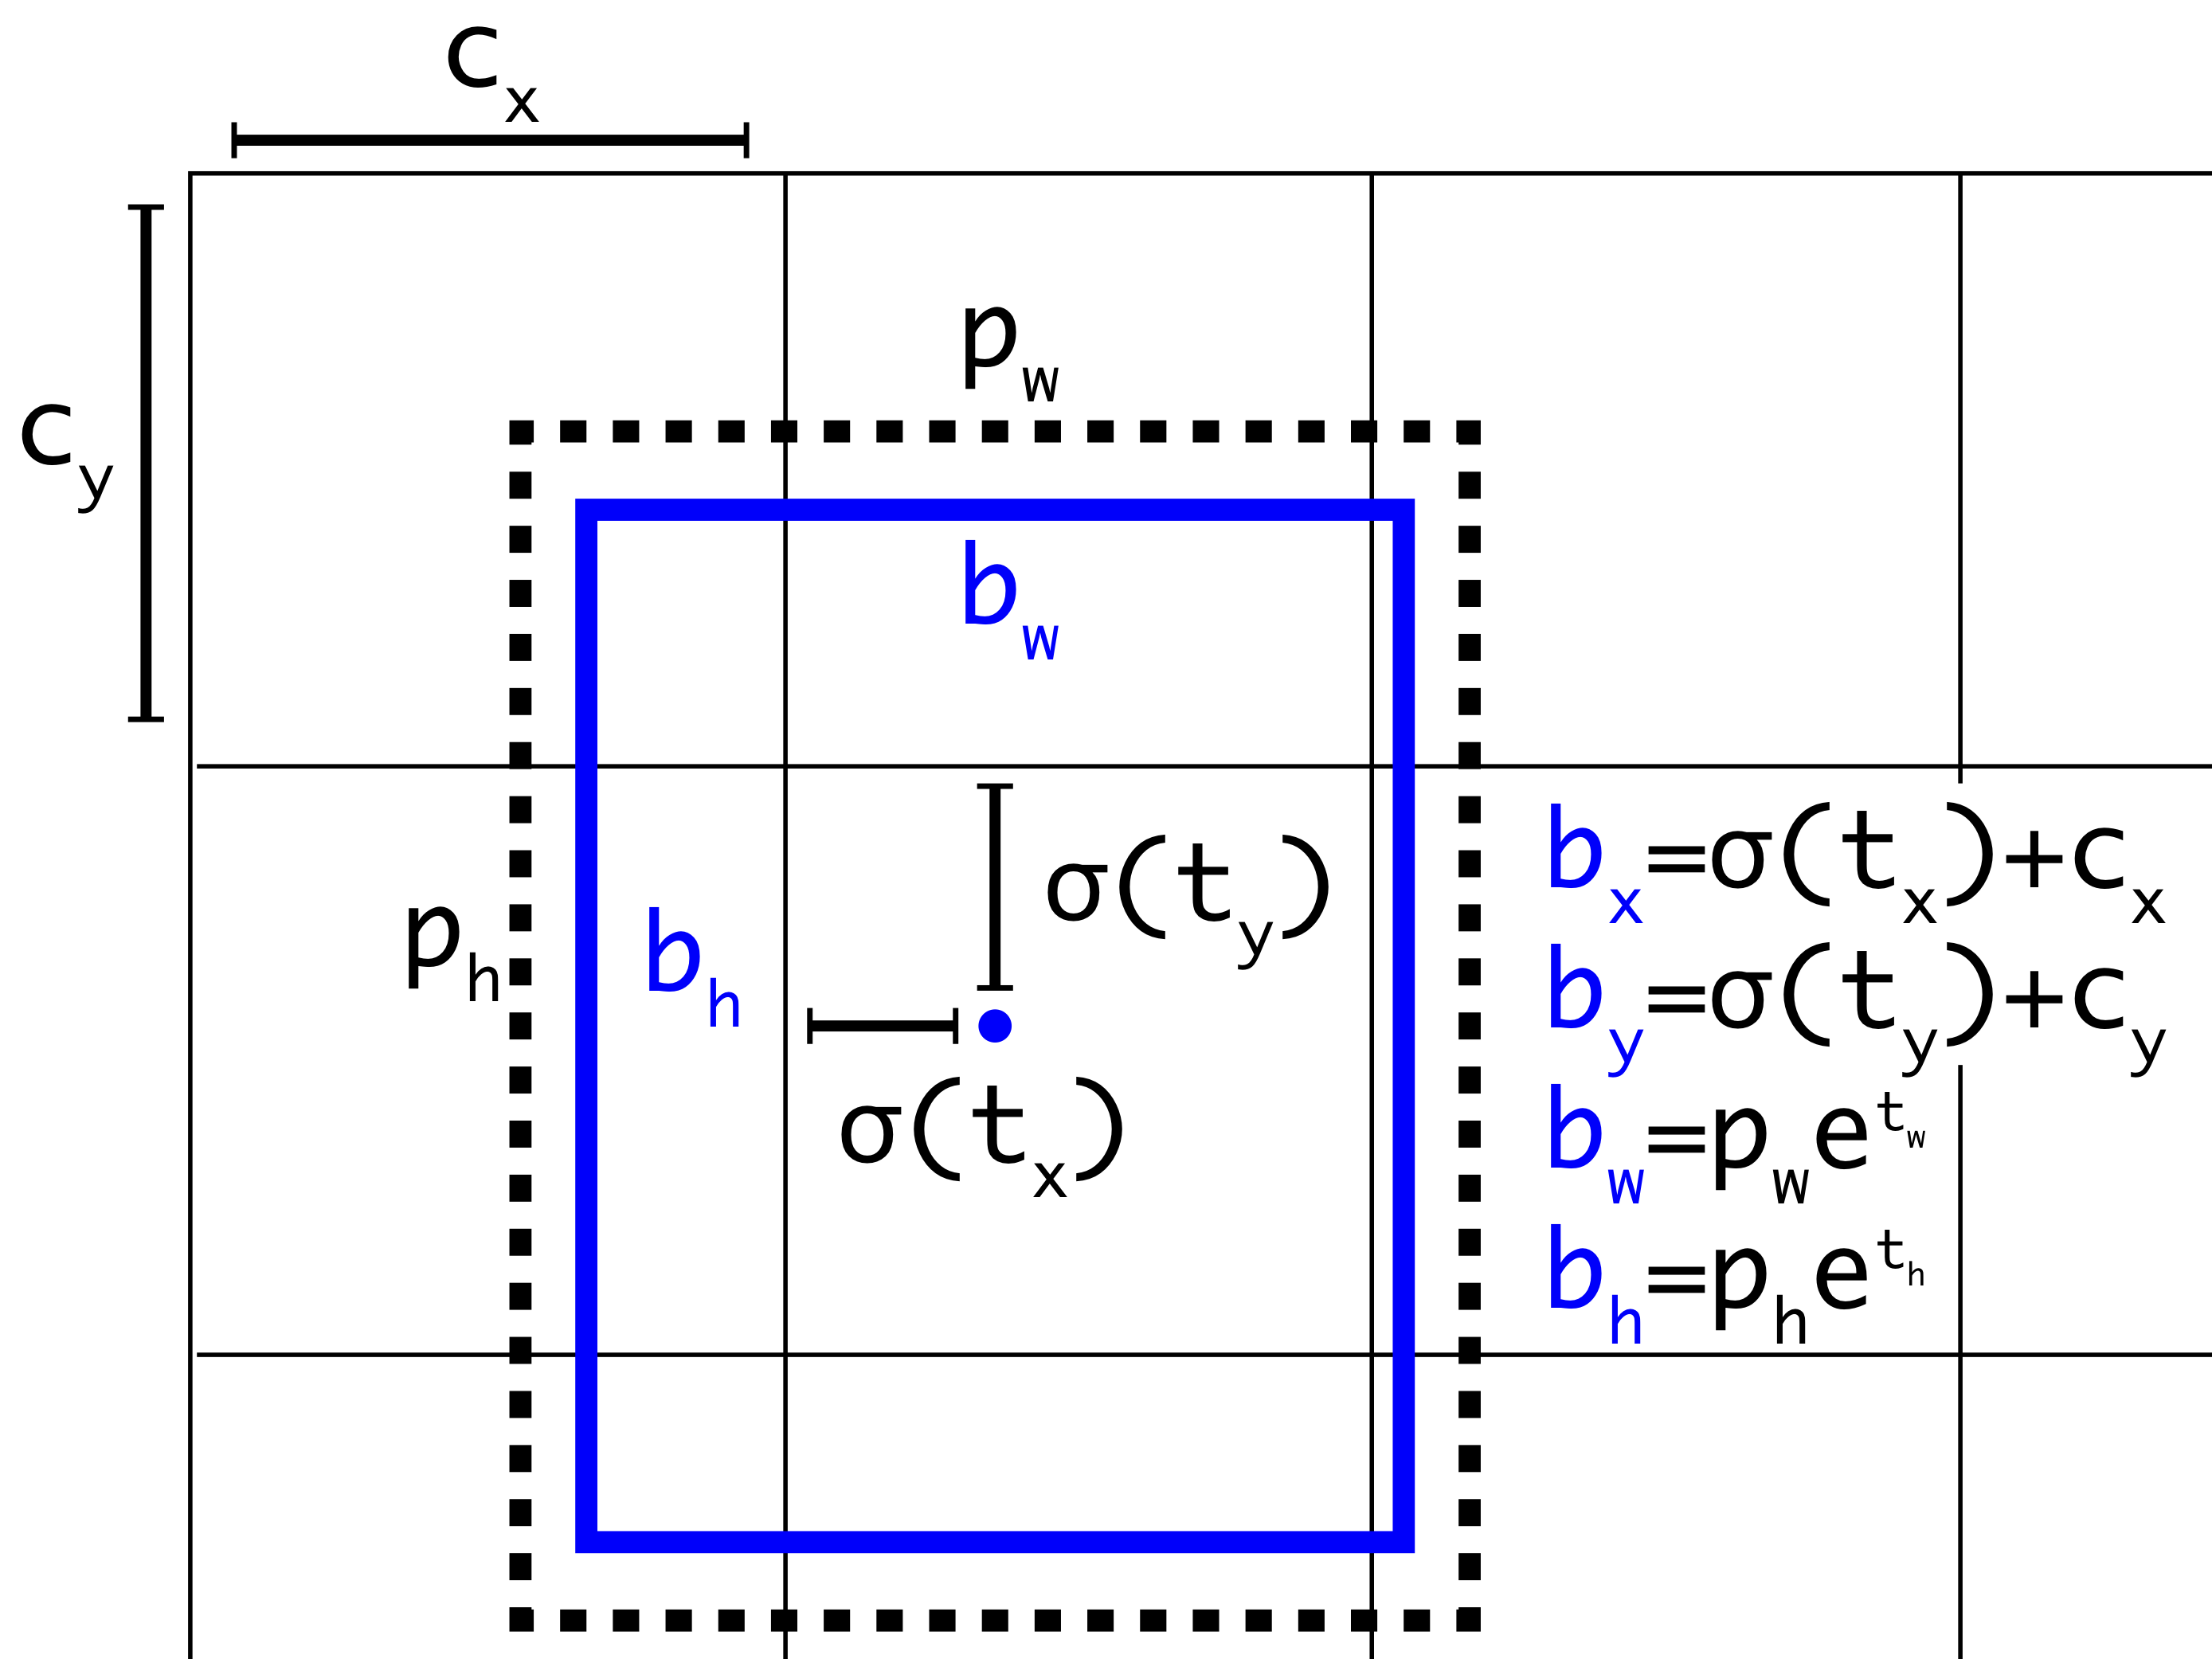

In [19]:
Image(filename="data/bbox.png", width=400, height=400)

Above is the illustration of 

In [20]:
def predict_transform(prediction, inp_dim, anchors, num_classes):
    batch_size = prediction.size(0)
    stride =  inp_dim // prediction.size(2)
    grid_size = inp_dim // stride
    bbox_attrs = 5 + num_classes
    num_anchors = len(anchors)

    prediction = prediction.view(batch_size, bbox_attrs*num_anchors, grid_size*grid_size)
    prediction = prediction.transpose(1,2).contiguous()
    prediction = prediction.view(batch_size, grid_size*grid_size*num_anchors, bbox_attrs)
    anchors = [(a[0]/stride, a[1]/stride) for a in anchors]

    # sigmoid centre_X, centre_Y. and object confidencce
    prediction[:,:,0] = torch.sigmoid(prediction[:,:,0])
    prediction[:,:,1] = torch.sigmoid(prediction[:,:,1])
    prediction[:,:,4] = torch.sigmoid(prediction[:,:,4])

    # add the center offsets
    grid = np.arange(grid_size)
    a,b = np.meshgrid(grid, grid)
    x_offset = torch.FloatTensor(a).view(-1,1)
    y_offset = torch.FloatTensor(b).view(-1,1)
    x_y_offset = torch.cat((x_offset, y_offset), 1).repeat(1,num_anchors).view(-1,2).unsqueeze(0)
    prediction[:,:,:2] += x_y_offset

    # log space transform height and the width
    anchors = torch.FloatTensor(anchors)
    anchors = anchors.repeat(grid_size*grid_size, 1).unsqueeze(0)
    prediction[:,:,2:4] = torch.exp(prediction[:,:,2:4])*anchors
    prediction[:,:,5: 5 + num_classes] = torch.sigmoid((prediction[:,:, 5 : 5 + num_classes]))
    prediction[:,:,:4] *= stride
    return prediction

In [21]:
def write_results(prediction, confidence, num_classes, nms_conf = 0.4):
    conf_mask = (prediction[:,:,4] > confidence).float().unsqueeze(2)
    prediction = prediction*conf_mask

    box_corner = prediction.new(prediction.shape)
    box_corner[:,:,0] = (prediction[:,:,0] - prediction[:,:,2]/2)
    box_corner[:,:,1] = (prediction[:,:,1] - prediction[:,:,3]/2)
    box_corner[:,:,2] = (prediction[:,:,0] + prediction[:,:,2]/2)
    box_corner[:,:,3] = (prediction[:,:,1] + prediction[:,:,3]/2)
    prediction[:,:,:4] = box_corner[:,:,:4]

    batch_size = prediction.size(0)
    write = False

    for ind in range(batch_size):
        image_pred = prediction[ind]
        # confidence threshholding
        # Non-max Suppression
        max_conf, max_conf_score = torch.max(image_pred[:,5:5+ num_classes], 1)
        max_conf = max_conf.float().unsqueeze(1)
        max_conf_score = max_conf_score.float().unsqueeze(1)
        seq = (image_pred[:,:5], max_conf, max_conf_score)
        image_pred = torch.cat(seq, 1)

        non_zero_ind =  (torch.nonzero(image_pred[:,4]))
        try: image_pred_ = image_pred[non_zero_ind.squeeze(),:].view(-1,7)
        except: continue

        if image_pred_.shape[0] == 0: continue

        # get the various classes detected in the image
        img_classes = unique(image_pred_[:,-1])  # -1 index holds the class index

        for cls in img_classes:
            # perform Non-max Suppression
            # get the detections with one particular class
            cls_mask = image_pred_*(image_pred_[:,-1] == cls).float().unsqueeze(1)
            class_mask_ind = torch.nonzero(cls_mask[:,-2]).squeeze()
            image_pred_class = image_pred_[class_mask_ind].view(-1,7)

            # sort the detections such that the entry with the maximum objectness
            # confidence is at the top
            conf_sort_index = torch.sort(image_pred_class[:,4], descending = True )[1]
            image_pred_class = image_pred_class[conf_sort_index]
            idx = image_pred_class.size(0)   #Number of detections

            for i in range(idx):
                # get the IOUs of all boxes that come after the one we are looking at
                try: ious = bbox_iou(image_pred_class[i].unsqueeze(0), image_pred_class[i+1:])
                except ValueError: break
                except IndexError: break

                # zero out all the detections that have IoU > treshhold
                iou_mask = (ious < nms_conf).float().unsqueeze(1)
                image_pred_class[i+1:] *= iou_mask

                # remove the non-zero entries
                non_zero_ind = torch.nonzero(image_pred_class[:,4]).squeeze()
                image_pred_class = image_pred_class[non_zero_ind].view(-1,7)

            batch_ind = image_pred_class.new(image_pred_class.size(0), 1).fill_(ind)      #Repeat the batch_id for as many detections of the class cls in the image
            seq = batch_ind, image_pred_class

            if not write:
                output = torch.cat(seq,1)
                write = True
            else:
                out = torch.cat(seq,1)
                output = torch.cat((output,out))
                
    try: return output
    except: return 0

    
def letterbox_image(img, inp_dim):
    '''resize image with unchanged aspect ratio using padding'''
    img_w, img_h = img.shape[1], img.shape[0]
    w, h = inp_dim
    new_w = int(img_w * min(w/img_w, h/img_h))
    new_h = int(img_h * min(w/img_w, h/img_h))
    resized_image = cv2.resize(img, (new_w,new_h), interpolation = cv2.INTER_CUBIC)
    canvas = np.full((inp_dim[1], inp_dim[0], 3), 128)
    canvas[(h-new_h)//2:(h-new_h)//2 + new_h,(w-new_w)//2:(w-new_w)//2 + new_w,  :] = resized_image
    return canvas


def prep_image(img, inp_dim):
    """
    Prepare image for inputting to the neural network.
    """
    img = (letterbox_image(img, (inp_dim, inp_dim)))
    img = img[:,:,::-1].transpose((2,0,1)).copy()
    img = torch.from_numpy(img).float().div(255.0).unsqueeze(0)
    return img


def load_classes(namesfile):
    fp = open(namesfile, "r")
    names = fp.read().split("\n")[:-1]
    return names

# Detection Output

<center>
<video width="400" height="250" src="road_video_compressed.mp4" type="video/mp4" controls>
</video>
</center>

In [22]:
# args = arg_parse()
# images = args.images
# batch_size = int(args.bs)
# confidence = float(args.confidence)
# nms_thesh = float(args.nms_thresh)
images = 'dog-cycle-car.png'
# input directory
images = 'images'
output_directory = 'output'
batch_size = 1
confidence = 0.5
nms_thesh = 0.4
start = 0

num_classes = 80
classes = load_classes("data/coco.names")

#Set up the neural network
print("Loading network.....")
model = Darknet('cfg/yolov3.cfg')
model.load_weights('yolov3.weights')
# model = Darknet(args.cfgfile)
# model.load_weights(args.weightsfile)
print("Network successfully loaded")
model.net_info["height"] = 416
# model.net_info["height"] = args.reso
inp_dim = int(model.net_info["height"])
assert inp_dim % 32 == 0
assert inp_dim > 32

#Set the model in evaluation mode
model.eval()

read_dir = time.time()
# detection phase
try: imlist = [osp.join(osp.realpath('.'), images, img) for img in os.listdir(images)]
except NotADirectoryError:
    imlist = []
    imlist.append(osp.join(osp.realpath('.'), images))
except FileNotFoundError:
    print ("No file or directory with the name {}".format(images))
    exit()

if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# if not os.path.exists(args.det):
#     os.makedirs(args.det)

load_batch = time.time()
loaded_ims = [cv2.imread(x) for x in imlist]

im_batches = list(map(prep_image, loaded_ims, [inp_dim for x in range(len(imlist))]))
im_dim_list = [(x.shape[1], x.shape[0]) for x in loaded_ims]
im_dim_list = torch.FloatTensor(im_dim_list).repeat(1,2)


leftover = 0
if (len(im_dim_list) % batch_size): leftover = 1
if batch_size != 1:
    num_batches = len(imlist) // batch_size + leftover
    im_batches = [torch.cat((im_batches[i*batch_size : min((i+1)*batch_size, len(im_batches))]))  for i in range(num_batches)]

write = 0

start_det_loop = time.time()
for i, batch in enumerate(im_batches):
    start = time.time()
    with torch.no_grad():
        prediction = model(Variable(batch))

    prediction = write_results(prediction, confidence, num_classes, nms_conf = nms_thesh)
    end = time.time()

    if type(prediction) == int:
        for im_num, image in enumerate(imlist[i*batch_size: min((i +  1)*batch_size, len(imlist))]):
            im_id = i*batch_size + im_num
            print("{0:20s} predicted in {1:6.3f} seconds".format(image.split("/")[-1], (end - start)/batch_size))
            print("{0:20s} {1:s}".format("Objects Detected:", ""))
            print("----------------------------------------------------------")
        continue

    prediction[:,0] += i*batch_size    #transform the atribute from index in batch to index in imlist

    if not write:                      #If we have't initialised output
        output = prediction
        write = 1
    else: output = torch.cat((output,prediction))

    for im_num, image in enumerate(imlist[i*batch_size: min((i +  1)*batch_size, len(imlist))]):
        im_id = i*batch_size + im_num
        objs = [classes[int(x[-1])] for x in output if int(x[0]) == im_id]
        print("{0:20s} predicted in {1:6.3f} seconds".format(image.split("/")[-1], (end - start)/batch_size))
        print("{0:20s} {1:s}".format("Objects Detected:", " ".join(objs)))
        print("----------------------------------------------------------")

try: output
except NameError:
    print ("No detections were made")
    exit()

im_dim_list = torch.index_select(im_dim_list, 0, output[:,0].long())
scaling_factor = torch.min(416/im_dim_list,1)[0].view(-1,1)
output[:,[1,3]] -= (inp_dim - scaling_factor*im_dim_list[:,0].view(-1,1))/2
output[:,[2,4]] -= (inp_dim - scaling_factor*im_dim_list[:,1].view(-1,1))/2
output[:,1:5] /= scaling_factor

for i in range(output.shape[0]):
    output[i, [1,3]] = torch.clamp(output[i, [1,3]], 0.0, im_dim_list[i,0])
    output[i, [2,4]] = torch.clamp(output[i, [2,4]], 0.0, im_dim_list[i,1])

output_recast = time.time()

class_load = time.time()
colors = pkl.load(open("pallete", "rb"))

draw = time.time()
def write(x, results):
    c1 = tuple(x[1:3].int())
    c2 = tuple(x[3:5].int())
    img = results[int(x[0])]
    cls = int(x[-1])
    color = random.choice(colors)
    label = "{0}".format(classes[cls])
    cv2.rectangle(img, c1, c2,color, 1)
    t_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_PLAIN, 1 , 1)[0]
    c2 = c1[0] + t_size[0] + 3, c1[1] + t_size[1] + 4
    cv2.rectangle(img, c1, c2,color, -1)
    cv2.putText(img, label, (c1[0], c1[1] + t_size[1] + 4), cv2.FONT_HERSHEY_PLAIN, 1, [225,255,255], 1);
    return img

list(map(lambda x: write(x, loaded_ims), output))
det_names = pd.Series(imlist).apply(lambda x: "{}/det_{}".format(output_directory,x.split("/")[-1]))
list(map(cv2.imwrite, det_names, loaded_ims))
end = time.time()

print("SUMMARY")
print("----------------------------------------------------------")
print("{:25s}: {}".format("Task", "Time Taken (in seconds)"))
print()
print("{:25s}: {:2.3f}".format("Reading addresses", load_batch - read_dir))
print("{:25s}: {:2.3f}".format("Loading batch", start_det_loop - load_batch))
print("{:25s}: {:2.3f}".format("Detection (" + str(len(imlist)) +  " images)", output_recast - start_det_loop))
print("{:25s}: {:2.3f}".format("Output Processing", class_load - output_recast))
print("{:25s}: {:2.3f}".format("Drawing Boxes", end - draw))
print("{:25s}: {:2.3f}".format("Average time_per_img", (end - load_batch)/len(imlist)))
print("----------------------------------------------------------")

Loading network.....
Network successfully loaded
0071.jpg             predicted in  0.669 seconds
Objects Detected:    car car car truck traffic light traffic light traffic light traffic light
----------------------------------------------------------
0065.jpg             predicted in  0.682 seconds
Objects Detected:    car car car car car car car traffic light traffic light traffic light traffic light traffic light
----------------------------------------------------------
0059.jpg             predicted in  0.740 seconds
Objects Detected:    car car car
----------------------------------------------------------
0105.jpg             predicted in  0.741 seconds
Objects Detected:    car car car car car
----------------------------------------------------------
0111.jpg             predicted in  0.707 seconds
Objects Detected:    car car car traffic light traffic light traffic light fire hydrant
----------------------------------------------------------


KeyboardInterrupt: 

In [ ]:
for file_name in os.listdir('output'):
    display(Image(filename='output/{0}'.format(file_name)))

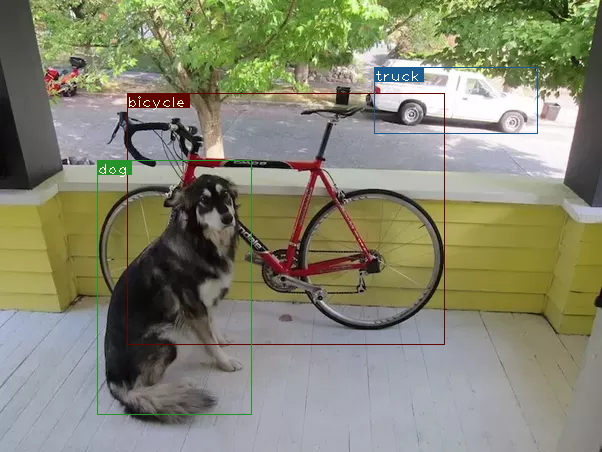

In [9]:
display(Image(filename='output/det_dog-cycle-car.png'))

In [10]:
videofile = args.videofile #or path to the video file. 

cap = cv2.VideoCapture(videofile)  

#cap = cv2.VideoCapture(0)  for webcam

assert cap.isOpened(), 'Cannot capture source'

frames = 0  
start = time.time()

while cap.isOpened():
    ret, frame = cap.read()
    
    if ret:   
        img = prep_image(frame, inp_dim)
#        cv2.imshow("a", frame)
        im_dim = frame.shape[1], frame.shape[0]
        im_dim = torch.FloatTensor(im_dim).repeat(1,2)   
        
        with torch.no_grad():
            output = model(Variable(img, volatile = True))
        output = write_results(output, confidence, num_classes, nms_conf = nms_thesh)


        if type(output) == int:
            frames += 1
            print("FPS of the video is {:5.4f}".format( frames / (time.time() - start)))
            cv2.imshow("frame", frame)
            key = cv2.waitKey(1)
            if key & 0xFF == ord('q'):
                break
            continue
        
        
        

        im_dim = im_dim.repeat(output.size(0), 1)
        scaling_factor = torch.min(416/im_dim,1)[0].view(-1,1)
        
        output[:,[1,3]] -= (inp_dim - scaling_factor*im_dim[:,0].view(-1,1))/2
        output[:,[2,4]] -= (inp_dim - scaling_factor*im_dim[:,1].view(-1,1))/2
        
        output[:,1:5] /= scaling_factor

        for i in range(output.shape[0]):
            output[i, [1,3]] = torch.clamp(output[i, [1,3]], 0.0, im_dim[i,0])
            output[i, [2,4]] = torch.clamp(output[i, [2,4]], 0.0, im_dim[i,1])
    
        classes = load_classes('data/coco.names')
        colors = pkl.load(open("pallete", "rb"))

        list(map(lambda x: write(x, frame), output))
        
        cv2.imshow("frame", frame)
        key = cv2.waitKey(1)
        if key & 0xFF == ord('q'):
            break
        frames += 1
        print(time.time() - start)
        print("FPS of the video is {:5.2f}".format( frames / (time.time() - start)))
    else:
        break

NameError: name 'args' is not defined

## References:
https://pjreddie.com/darknet/yolo/ <br />
https://blog.paperspace.com/tag/series-yolo/